## Library Dependencies and Package Imports

Loading essential libraries for molecular property prediction using Message Passing Neural Networks

In [3]:
# Environment configuration for cleaner output
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress TensorFlow logging

# Core deep learning framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Scientific computing and data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utility modules
import warnings

# Chemical informatics toolkit
from rdkit import Chem, RDLogger
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

# Configure warning suppression and logging
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

# Set random seeds for reproducibility
REPRODUCIBILITY_CONSTANT = 42
np.random.seed(REPRODUCIBILITY_CONSTANT)
tf.random.set_seed(REPRODUCIBILITY_CONSTANT)

# Reset to default matplotlib style
plt.rcdefaults()
sns.reset_defaults()

### Data Loading and Initial Exploration

Load the blood-brain barrier penetration dataset and display sample data for verification.

In [4]:
MOLECULAR_DATASET_SOURCE = 'BBBP_combined.csv'
brain_barrier_dataset = pd.read_csv(MOLECULAR_DATASET_SOURCE, usecols=[1, 2, 3])
brain_barrier_dataset.iloc[96:104]

,name,label,smiles
96,dihydrostreptomycin,0,CN[C@H]1[C@H](O)[C@@H](O)[C@H](CO)O[C@H]1O[C@H...
97,aminoglutethimide,1,C1=CC(=CC=C1C2(C(NC(=O)CC2)=O)CC)N
98,cyclophenazine,1,FC(F)(F)c1ccc2Sc3ccccc3N(CCCN4CCN(CC4)C5CC5)c2c1
99,arfendazam,1,C1=C(Cl)C=CC3=C1N(C2=CC=CC=C2)C(CCN3C(OCC)=O)=O
100,melphalan,0,NC(Cc1ccc(cc1)N(CCCl)CCCl)C(O)=O
101,carbuterol,0,CC(C)(C)NCC(O)c1ccc(O)c(NC(N)=O)c1
102,compound 36,1,CN(C)Cc1ccc(CSCCNC2=C([N+]([O-])=O)C(Cc3ccccc3...
103,3-methylhexane,1,CCCC(C)CC


In [5]:
molecular_dataframe = brain_barrier_dataset.rename(columns={'label': 'permeability_target'})

### Molecular Featurization Classes

Define base featurizer class and specialized classes for atomic and bond feature encoding. These classes convert molecular properties into numerical vectors suitable for machine learning.

In [6]:
import numpy as np

class MolecularPropertyEncoder:
    def __init__(self, permitted_value_sets):
        self.total_dimensions = 0
        self.property_mapping_dict = {}
        
        for property_identifier, permitted_values in permitted_value_sets.items():
            ordered_values = sorted(list(permitted_values))
            index_mapping = dict(zip(ordered_values, range(self.total_dimensions, len(ordered_values) + self.total_dimensions)))
            self.property_mapping_dict[property_identifier] = index_mapping
            self.total_dimensions += len(ordered_values)

    def transform_to_vector(self, molecular_component):
        encoding_vector = np.zeros((self.total_dimensions,))
        
        for property_identifier, index_mapping in self.property_mapping_dict.items():
            extracted_property = getattr(self, property_identifier)(molecular_component)
            if extracted_property in index_mapping:
                encoding_vector[index_mapping[extracted_property]] = 1.0
                
        return encoding_vector


class AtomicPropertyEncoder(MolecularPropertyEncoder):
    def __init__(self, permitted_value_sets):
        super().__init__(permitted_value_sets)

    def symbol(self, atomic_structure):
        return atomic_structure.GetSymbol()

    def n_valence(self, atomic_structure):
        return atomic_structure.GetTotalValence()

    def n_hydrogens(self, atomic_structure):
        return atomic_structure.GetTotalNumHs()

    def hybridization(self, atomic_structure):
        return atomic_structure.GetHybridization().name.lower()


class BondPropertyEncoder(MolecularPropertyEncoder):
    def __init__(self, permitted_value_sets):
        super().__init__(permitted_value_sets)
        self.total_dimensions += 1

    def transform_to_vector(self, chemical_bond):
        encoding_vector = np.zeros((self.total_dimensions,))
        
        if chemical_bond is None:
            encoding_vector[-1] = 1.0
            return encoding_vector
            
        encoding_vector = super().transform_to_vector(chemical_bond)
        return encoding_vector

    def bond_type(self, chemical_bond):
        return chemical_bond.GetBondType().name.lower()

    def conjugated(self, chemical_bond):
        return chemical_bond.GetIsConjugated()


atomic_property_processor = AtomicPropertyEncoder(
    permitted_value_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_property_processor = BondPropertyEncoder(
    permitted_value_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)


### Molecular Processing and Graph Conversion

Functions to convert SMILES strings to RDKit molecules and transform them into graph representations suitable for neural networks. Includes data splitting for training, validation, and testing.

In [7]:
def convert_smiles_to_molecule(molecular_string):
    chemical_structure = Chem.MolFromSmiles(molecular_string, sanitize=False)
    cleaning_result = Chem.SanitizeMol(chemical_structure, catchErrors=True)
    
    if cleaning_result != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(chemical_structure, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ cleaning_result)

    Chem.AssignStereochemistry(chemical_structure, cleanIt=True, force=True)
    return chemical_structure


def extract_molecular_graph(molecular_structure):
    atom_property_vectors = []
    bond_property_vectors = []
    connection_index_pairs = []

    for atomic_node in molecular_structure.GetAtoms():
        atom_property_vectors.append(atomic_property_processor.transform_to_vector(atomic_node))

        current_atom_id = atomic_node.GetIdx()
        connection_index_pairs.append([current_atom_id, current_atom_id])
        bond_property_vectors.append(bond_property_processor.transform_to_vector(None))

        for adjacent_atom in atomic_node.GetNeighbors():
            adjacent_atom_id = adjacent_atom.GetIdx()
            linking_bond = molecular_structure.GetBondBetweenAtoms(current_atom_id, adjacent_atom_id)
            
            connection_index_pairs.append([current_atom_id, adjacent_atom_id])
            bond_property_vectors.append(bond_property_processor.transform_to_vector(linking_bond))

    return (np.array(atom_property_vectors), 
            np.array(bond_property_vectors), 
            np.array(connection_index_pairs))


def process_smiles_collection(molecular_string_list):
    collected_atom_properties = []
    collected_bond_properties = []
    collected_connectivity_indices = []

    for molecular_string in molecular_string_list:
        chemical_structure = convert_smiles_to_molecule(molecular_string)
        atom_props, bond_props, connectivity_props = extract_molecular_graph(chemical_structure)

        collected_atom_properties.append(atom_props)
        collected_bond_properties.append(bond_props)
        collected_connectivity_indices.append(connectivity_props)

    return (
        tf.ragged.constant(collected_atom_properties, dtype=tf.float32),
        tf.ragged.constant(collected_bond_properties, dtype=tf.float32),
        tf.ragged.constant(collected_connectivity_indices, dtype=tf.int64),
    )


total_dataset_size = molecular_dataframe.shape[0]
randomized_sample_indices = np.random.permutation(np.arange(total_dataset_size))

TRAINING_DATA_FRACTION = 0.8
VALIDATION_DATA_FRACTION = 0.19

training_split_boundary = int(total_dataset_size * TRAINING_DATA_FRACTION)
validation_split_boundary = int(total_dataset_size * (TRAINING_DATA_FRACTION + VALIDATION_DATA_FRACTION))

training_sample_indices = randomized_sample_indices[:training_split_boundary]
molecular_features_train = process_smiles_collection(molecular_dataframe.iloc[training_sample_indices].smiles)
permeability_labels_train = molecular_dataframe.iloc[training_sample_indices].permeability_target

validation_sample_indices = randomized_sample_indices[training_split_boundary:validation_split_boundary]
molecular_features_validation = process_smiles_collection(molecular_dataframe.iloc[validation_sample_indices].smiles)
permeability_labels_validation = molecular_dataframe.iloc[validation_sample_indices].permeability_target

testing_sample_indices = randomized_sample_indices[validation_split_boundary:]
molecular_features_test = process_smiles_collection(molecular_dataframe.iloc[testing_sample_indices].smiles)
permeability_labels_test = molecular_dataframe.iloc[testing_sample_indices].permeability_target

## Function Validation and Testing


Compound Name: methaqualone
SMILES String: Cc1ccccc1N2C(=Nc3ccccc3C2=O)C
BBB Penetration: 1

Molecular Structure:


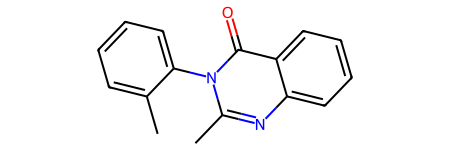

In [8]:
# Select a sample molecule for demonstration
SAMPLE_INDEX = 34


# Display molecular information
compound_identifier = molecular_dataframe.name[SAMPLE_INDEX]
molecular_representation = molecular_dataframe.smiles[SAMPLE_INDEX]
barrier_permeability_value = molecular_dataframe.permeability_target[SAMPLE_INDEX]

print(f"Compound Name: {compound_identifier}")
print(f"SMILES String: {molecular_representation}")
print(f"BBB Penetration: {barrier_permeability_value}")

# Generate molecule object for visualization
demonstration_molecule = convert_smiles_to_molecule(molecular_representation)
print("\nMolecular Structure:")
demonstration_molecule

In [9]:
# Convert sample molecule to graph representation
demonstration_molecular_graph = extract_molecular_graph(demonstration_molecule)

print("Molecular Graph Structure (including self-connections):")
print(f"Atomic features: {demonstration_molecular_graph[0].shape}")
print(f"Bond features: {demonstration_molecular_graph[1].shape}")
print(f"Connectivity pairs: {demonstration_molecular_graph[2].shape}")


Molecular Graph Structure (including self-connections):
Atomic features: (19, 29)
Bond features: (61, 7)
Connectivity pairs: (61, 2)


In [10]:
def consolidate_molecular_batch(batch_molecular_data, batch_target_labels):
    """
    Consolidate multiple molecular graphs into a single disconnected graph.
    Essential for batch processing in graph neural networks.
    """
    atom_property_tensors, bond_property_tensors, connectivity_index_tensors = batch_molecular_data

    # Calculate graph sizes for each molecule
    atom_count_per_molecule = atom_property_tensors.row_lengths()
    bond_count_per_molecule = bond_property_tensors.row_lengths()

    # Generate molecule indicators for graph partitioning
    molecule_identification_indices = tf.range(len(atom_count_per_molecule))
    molecule_assignment_vector = tf.repeat(molecule_identification_indices, atom_count_per_molecule)

    # Merge individual graphs into global disconnected graph
    # Adjust connectivity indices to account for concatenation
    gathering_indices = tf.repeat(molecule_identification_indices[:-1], bond_count_per_molecule[1:])
    cumulative_offset = tf.cumsum(atom_count_per_molecule[:-1])
    padded_offset = tf.pad(tf.gather(cumulative_offset, gathering_indices), [(bond_count_per_molecule[0], 0)])
    
    # Convert ragged tensors to regular tensors
    connectivity_index_tensors = connectivity_index_tensors.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    connectivity_index_tensors = connectivity_index_tensors + padded_offset[:, tf.newaxis]
    atom_property_tensors = atom_property_tensors.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_property_tensors = bond_property_tensors.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_property_tensors, bond_property_tensors, connectivity_index_tensors, molecule_assignment_vector), batch_target_labels


def create_molecular_neural_dataset(molecular_feature_data, target_label_data, batch_size=32, shuffle=False):
    """
    Create TensorFlow dataset optimized for MPNN training.
    Handles variable-size molecular graphs efficiently.
    """
    # Create base dataset from features and labels
    tensorflow_dataset = tf.data.Dataset.from_tensor_slices((molecular_feature_data, target_label_data))
    
    # Apply shuffling if requested
    if shuffle:
        tensorflow_dataset = tensorflow_dataset.shuffle(buffer_size=1024)
    
    # Batch data and apply graph merging transformation
    return tensorflow_dataset.batch(batch_size).map(consolidate_molecular_batch, num_parallel_calls=-1).prefetch(tf.data.AUTOTUNE)


### Batch Processing and Neural Network Layers

Implementation of batch preparation functions and custom neural network layers for message passing neural networks including edge networks, message passing layers, and transformer-based readout mechanisms.

In [11]:
from tensorflow.keras import layers
import tensorflow as tf

class BondInformationProcessor(layers.Layer):
    """
    Neural network layer for processing edge information in molecular graphs.
    Transforms bond features and aggregates neighbor information.
    """
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        self.atomic_feature_dimension = input_shape[0][-1]
        self.bond_feature_dimension = input_shape[1][-1]
        
        self.transformation_kernel = self.add_weight(
            shape=(self.bond_feature_dimension, self.atomic_feature_dimension),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.transformation_bias = self.add_weight(
            shape=(self.atomic_feature_dimension,), 
            initializer="zeros", 
            name="bias",
        )
        self.built = True

    def call(self, inputs):
        """Process edge information and aggregate neighbor features"""
        atomic_property_features, bond_property_features, connectivity_indices = inputs

        # Transform bond features through linear layer
        processed_bond_features = tf.matmul(bond_property_features, self.transformation_kernel) + self.transformation_bias

        # Gather neighbor atom features using connectivity information
        neighboring_atomic_features = tf.gather(atomic_property_features, connectivity_indices[:, 1])
        
        # Combine bond and atom information via element-wise multiplication
        merged_feature_information = processed_bond_features * neighboring_atomic_features
        
        # Aggregate features for each atom by summing contributions from all edges
        aggregated_neighborhood_features = tf.math.unsorted_segment_sum(
            merged_feature_information,
            connectivity_indices[:, 0],
            num_segments=tf.shape(atomic_property_features)[0],
        )
        return aggregated_neighborhood_features


class IterativeMessagePropagation(layers.Layer):
    """
    Core message passing layer implementing iterative information propagation.
    Updates node representations through multiple rounds of neighbor aggregation.
    """
    
    def __init__(self, hidden_units, propagation_steps=4, **kwargs):
        super().__init__(**kwargs)
        self.hidden_units = hidden_units
        self.propagation_steps = propagation_steps

    def build(self, input_shape):
        # Store original atom dimensionality
        self.atomic_feature_dimension = input_shape[0][-1]
        
        # Initialize edge processing network
        self.bond_information_processor = BondInformationProcessor()
        
        # Calculate padding needed to match desired units
        self.dimension_padding_length = max(0, self.hidden_units - self.atomic_feature_dimension)
        
        # GRU cell for updating node states
        self.state_update_mechanism = layers.GRUCell(self.hidden_units)
        self.built = True

    def call(self, inputs):
        """Execute multiple rounds of message passing"""
        atomic_property_features, bond_property_features, connectivity_indices = inputs

        # Initialize node states with padding to match GRU input size
        padded_node_states = tf.pad(atomic_property_features, [(0, 0), (0, self.dimension_padding_length)])

        # Iterative message passing updates
        for propagation_iteration in range(self.propagation_steps):
            # Aggregate information from neighbors using original atom features
            aggregated_neighbor_information = self.bond_information_processor(
                [atomic_property_features, bond_property_features, connectivity_indices]
            )
            
            # Pad aggregated messages to match GRU dimensions
            padded_neighbor_messages = tf.pad(aggregated_neighbor_information, [(0, 0), (0, self.dimension_padding_length)])

            # Update node states using GRU mechanism
            padded_node_states, _ = self.state_update_mechanism(padded_neighbor_messages, padded_node_states)
            
        return padded_node_states


In [12]:
class MolecularBatchPartitioner(layers.Layer):
    """
    Layer for partitioning and padding molecular graphs within batches.
    Handles variable-size molecules by padding to maximum size in batch.
    """
    
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):
        """Partition and pad molecular graphs for uniform processing"""
        atomic_node_features, molecule_assignment_indices = inputs

        # Separate features by molecule using partition indices
        separated_molecular_features = tf.dynamic_partition(
            atomic_node_features, molecule_assignment_indices, self.batch_size
        )

        # Calculate atom counts and find maximum for padding
        atom_counts_per_molecule = [tf.shape(molecular_features)[0] for molecular_features in separated_molecular_features]
        maximum_atoms_in_batch = tf.reduce_max(atom_counts_per_molecule)
        
        # Pad each molecular graph to maximum size and stack
        uniformly_padded_molecules = tf.stack([
            tf.pad(molecular_features, [(0, maximum_atoms_in_batch - atom_count), (0, 0)])
            for molecular_features, atom_count in zip(separated_molecular_features, atom_counts_per_molecule)
        ], axis=0)

        # Filter out empty molecules (typically from incomplete final batch)
        non_empty_molecule_mask = tf.where(tf.reduce_sum(uniformly_padded_molecules, (1, 2)) != 0)
        valid_molecule_indices = tf.squeeze(non_empty_molecule_mask, axis=-1)
        
        return tf.gather(uniformly_padded_molecules, valid_molecule_indices, axis=0)


class AttentionBasedMolecularReadout(layers.Layer):
    """
    Transformer-based readout layer for molecular-level predictions.
    Uses self-attention to aggregate atom-level features into molecule representations.
    """
    
    def __init__(self, attention_head_count=8, embedding_dimensions=64, dense_layer_units=512, batch_size=32, **kwargs):
        super().__init__(**kwargs)

        # Initialize sub-layers
        self.molecular_batch_partitioner = MolecularBatchPartitioner(batch_size)
        self.multi_head_attention_mechanism = layers.MultiHeadAttention(attention_head_count, embedding_dimensions)
        
        # Feed-forward network
        self.feedforward_projection = keras.Sequential([
            layers.Dense(dense_layer_units, activation="relu"), 
            layers.Dense(embedding_dimensions),
        ])
        
        # Normalization layers
        self.attention_layer_normalization = layers.LayerNormalization()
        self.feedforward_layer_normalization = layers.LayerNormalization()
        
        # Global pooling for final aggregation
        self.global_molecular_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        """Apply transformer encoding and global pooling for molecular representation"""
        # Partition and pad molecular graphs
        partitioned_molecular_input = self.molecular_batch_partitioner(inputs)
        
        # Create padding mask for attention mechanism
        attention_padding_mask = tf.reduce_any(tf.not_equal(partitioned_molecular_input, 0.0), axis=-1)
        reshaped_attention_mask = attention_padding_mask[:, tf.newaxis, tf.newaxis, :]
        
        # Self-attention with residual connection
        attention_processed_output = self.multi_head_attention_mechanism(
            partitioned_molecular_input, partitioned_molecular_input, attention_mask=reshaped_attention_mask
        )
        attention_residual_output = self.attention_layer_normalization(partitioned_molecular_input + attention_processed_output)
        
        # Feed-forward network with residual connection
        feedforward_processed_output = self.feedforward_projection(attention_residual_output)
        feedforward_residual_output = self.feedforward_layer_normalization(attention_residual_output + feedforward_processed_output)
        
        # Global average pooling for final molecular representation
        return self.global_molecular_pooling(feedforward_residual_output)


In [13]:
representative_atomic_features = molecular_features_train[0][0][0]
representative_bond_features = molecular_features_train[1][0][0]

print("Feature Dimension Analysis")
print(f"Atom feature vector shape: {representative_atomic_features.shape}")
print(f"Bond feature vector shape: {representative_bond_features.shape}")
print(f"Atom dimension: {representative_atomic_features.shape[0]}")
print(f"Bond dimension: {representative_bond_features.shape[0]}")
print(f"Atom dimension squared: {representative_atomic_features.shape[0] ** 2}")

Feature Dimension Analysis
Atom feature vector shape: (29,)
Bond feature vector shape: (7,)
Atom dimension: 29
Bond dimension: 7
Atom dimension squared: 841


### Model Construction and Compilation

Create the complete MPNN model by combining message passing layers with transformer readout mechanism. Configure the model for binary classification training.

In [14]:
def construct_molecular_neural_network(atomic_feature_dimensions, bond_feature_dimensions, batch_size=32, message_passing_units=64, 
                      propagation_iterations=4, attention_head_count=8, dense_processing_units=512):
    
    atomic_feature_input = layers.Input((atomic_feature_dimensions,), dtype="float32", name="atom_features")
    bond_feature_input = layers.Input((bond_feature_dimensions,), dtype="float32", name="bond_features")
    connectivity_input = layers.Input((2,), dtype="int32", name="pair_indices")
    molecular_identifier_input = layers.Input((), dtype="int32", name="molecule_indicator")

    message_propagated_features = IterativeMessagePropagation(message_passing_units, propagation_iterations)(
        [atomic_feature_input, bond_feature_input, connectivity_input]
    )

    molecular_level_representation = AttentionBasedMolecularReadout(
        attention_head_count, message_passing_units, dense_processing_units, batch_size
    )([message_propagated_features, molecular_identifier_input])

    intermediate_dense_representation = layers.Dense(dense_processing_units, activation="relu")(molecular_level_representation)
    final_prediction_output = layers.Dense(1, activation="sigmoid")(intermediate_dense_representation)

    completed_neural_network = keras.Model(
        inputs=[atomic_feature_input, bond_feature_input, connectivity_input, molecular_identifier_input],
        outputs=[final_prediction_output],
    )
    return completed_neural_network


brain_barrier_prediction_model = construct_molecular_neural_network(
    atomic_feature_dimensions=molecular_features_train[0][0][0].shape[0], 
    bond_feature_dimensions=molecular_features_train[1][0][0].shape[0],
)

brain_barrier_prediction_model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.AUC(name="AUC")],
)

try:
    keras.utils.plot_model(brain_barrier_prediction_model, show_dtype=True, show_shapes=True)
except:
    print("Model architecture visualization requires graphviz installation")

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## Model Training and Optimization

Training the MPNN on blood-brain barrier penetration prediction task

Starting MPNN training with early stopping...
Epoch 1/40

Epoch 1: val_AUC improved from -inf to 0.77694, saving model to best_mpnn_model.h5


78/78 - 10s - 134ms/step - AUC: 0.7356 - loss: 0.5499 - val_AUC: 0.7769 - val_loss: 0.6949 - learning_rate: 5.0000e-04
Epoch 2/40

Epoch 2: val_AUC improved from 0.77694 to 0.80556, saving model to best_mpnn_model.h5


78/78 - 6s - 76ms/step - AUC: 0.8122 - loss: 0.4860 - val_AUC: 0.8056 - val_loss: 0.6429 - learning_rate: 5.0000e-04
Epoch 3/40

Epoch 3: val_AUC improved from 0.80556 to 0.82863, saving model to best_mpnn_model.h5


78/78 - 7s - 84ms/step - AUC: 0.8319 - loss: 0.4668 - val_AUC: 0.8286 - val_loss: 0.5831 - learning_rate: 5.0000e-04
Epoch 4/40

Epoch 4: val_AUC improved from 0.82863 to 0.84411, saving model to best_mpnn_model.h5


78/78 - 7s - 86ms/step - AUC: 0.8478 - loss: 0.4493 - val_AUC: 0.8441 - val_loss: 0.5804 - learning_rate: 5.0000e-04
Epoch 5/40

Epoch 5: val_AUC improved from 0.84411 to 0.85840, saving model to best_mpnn_model.h5


78/78 - 6s - 77ms/step - AUC: 0.8617 - loss: 0.4314 - val_AUC: 0.8584 - val_loss: 0.5729 - learning_rate: 5.0000e-04
Epoch 6/40

Epoch 6: val_AUC improved from 0.85840 to 0.86976, saving model to best_mpnn_model.h5


78/78 - 6s - 83ms/step - AUC: 0.8724 - loss: 0.4153 - val_AUC: 0.8698 - val_loss: 0.5467 - learning_rate: 5.0000e-04
Epoch 7/40

Epoch 7: val_AUC improved from 0.86976 to 0.87028, saving model to best_mpnn_model.h5


78/78 - 7s - 85ms/step - AUC: 0.8784 - loss: 0.4041 - val_AUC: 0.8703 - val_loss: 0.6064 - learning_rate: 5.0000e-04
Epoch 8/40

Epoch 8: val_AUC did not improve from 0.87028
78/78 - 6s - 78ms/step - AUC: 0.8827 - loss: 0.3965 - val_AUC: 0.8542 - val_loss: 0.6821 - learning_rate: 5.0000e-04
Epoch 9/40

Epoch 9: val_AUC did not improve from 0.87028
78/78 - 6s - 79ms/step - AUC: 0.8851 - loss: 0.3931 - val_AUC: 0.8492 - val_loss: 0.7084 - learning_rate: 5.0000e-04
Epoch 10/40

Epoch 10: val_AUC did not improve from 0.87028
78/78 - 6s - 79ms/step - AUC: 0.8910 - loss: 0.3852 - val_AUC: 0.8394 - val_loss: 0.7072 - learning_rate: 5.0000e-04
Epoch 11/40

Epoch 11: val_AUC did not improve from 0.87028
78/78 - 6s - 82ms/step - AUC: 0.8967 - loss: 0.3736 - val_AUC: 0.8437 - val_loss: 0.7030 - learning_rate: 5.0000e-04
Epoch 12/40

Epoch 12: val_AUC improved from 0.87028 to 0.87688, saving model to best_mpnn_model.h5


78/78 - 6s - 75ms/step - AUC: 0.9004 - loss: 0.3678 - val_AUC: 0.8769 - val_loss: 0.7055 - learning_rate: 5.0000e-04
Epoch 13/40

Epoch 13: val_AUC did not improve from 0.87688
78/78 - 6s - 74ms/step - AUC: 0.9052 - loss: 0.3551 - val_AUC: 0.8692 - val_loss: 0.7782 - learning_rate: 5.0000e-04
Epoch 14/40

Epoch 14: val_AUC improved from 0.87688 to 0.87892, saving model to best_mpnn_model.h5


78/78 - 6s - 71ms/step - AUC: 0.9053 - loss: 0.3546 - val_AUC: 0.8789 - val_loss: 0.8126 - learning_rate: 5.0000e-04
Epoch 15/40

Epoch 15: val_AUC improved from 0.87892 to 0.88579, saving model to best_mpnn_model.h5


78/78 - 6s - 75ms/step - AUC: 0.9103 - loss: 0.3467 - val_AUC: 0.8858 - val_loss: 0.7314 - learning_rate: 5.0000e-04
Epoch 16/40

Epoch 16: val_AUC did not improve from 0.88579
78/78 - 6s - 74ms/step - AUC: 0.9177 - loss: 0.3299 - val_AUC: 0.8775 - val_loss: 0.7494 - learning_rate: 5.0000e-04
Epoch 17/40

Epoch 17: val_AUC did not improve from 0.88579
78/78 - 6s - 75ms/step - AUC: 0.9179 - loss: 0.3310 - val_AUC: 0.8841 - val_loss: 0.7308 - learning_rate: 5.0000e-04
Epoch 18/40

Epoch 18: val_AUC improved from 0.88579 to 0.88996, saving model to best_mpnn_model.h5


78/78 - 6s - 74ms/step - AUC: 0.9226 - loss: 0.3207 - val_AUC: 0.8900 - val_loss: 0.7342 - learning_rate: 5.0000e-04
Epoch 19/40

Epoch 19: val_AUC improved from 0.88996 to 0.89945, saving model to best_mpnn_model.h5


78/78 - 6s - 77ms/step - AUC: 0.9259 - loss: 0.3117 - val_AUC: 0.8995 - val_loss: 0.7313 - learning_rate: 5.0000e-04
Epoch 20/40

Epoch 20: val_AUC improved from 0.89945 to 0.89955, saving model to best_mpnn_model.h5


78/78 - 6s - 78ms/step - AUC: 0.9319 - loss: 0.2998 - val_AUC: 0.8996 - val_loss: 0.7650 - learning_rate: 5.0000e-04
Epoch 21/40

Epoch 21: val_AUC improved from 0.89955 to 0.90002, saving model to best_mpnn_model.h5


78/78 - 6s - 76ms/step - AUC: 0.9336 - loss: 0.2903 - val_AUC: 0.9000 - val_loss: 0.6990 - learning_rate: 5.0000e-04
Epoch 22/40

Epoch 22: val_AUC did not improve from 0.90002
78/78 - 6s - 78ms/step - AUC: 0.9382 - loss: 0.2808 - val_AUC: 0.9000 - val_loss: 0.7498 - learning_rate: 5.0000e-04
Epoch 23/40

Epoch 23: val_AUC improved from 0.90002 to 0.90488, saving model to best_mpnn_model.h5


78/78 - 6s - 77ms/step - AUC: 0.9375 - loss: 0.2800 - val_AUC: 0.9049 - val_loss: 0.7741 - learning_rate: 5.0000e-04
Epoch 24/40

Epoch 24: val_AUC improved from 0.90488 to 0.91579, saving model to best_mpnn_model.h5


78/78 - 6s - 80ms/step - AUC: 0.9405 - loss: 0.2768 - val_AUC: 0.9158 - val_loss: 0.7116 - learning_rate: 5.0000e-04
Epoch 25/40

Epoch 25: val_AUC improved from 0.91579 to 0.91860, saving model to best_mpnn_model.h5


78/78 - 6s - 78ms/step - AUC: 0.9450 - loss: 0.2646 - val_AUC: 0.9186 - val_loss: 0.6872 - learning_rate: 5.0000e-04
Epoch 26/40

Epoch 26: val_AUC improved from 0.91860 to 0.92163, saving model to best_mpnn_model.h5


78/78 - 6s - 80ms/step - AUC: 0.9500 - loss: 0.2493 - val_AUC: 0.9216 - val_loss: 0.6292 - learning_rate: 5.0000e-04
Epoch 27/40

Epoch 27: val_AUC improved from 0.92163 to 0.92902, saving model to best_mpnn_model.h5


78/78 - 6s - 79ms/step - AUC: 0.9510 - loss: 0.2479 - val_AUC: 0.9290 - val_loss: 0.6067 - learning_rate: 5.0000e-04
Epoch 28/40

Epoch 28: val_AUC did not improve from 0.92902
78/78 - 6s - 78ms/step - AUC: 0.9516 - loss: 0.2411 - val_AUC: 0.9267 - val_loss: 0.6109 - learning_rate: 5.0000e-04
Epoch 29/40

Epoch 29: val_AUC improved from 0.92902 to 0.93216, saving model to best_mpnn_model.h5


78/78 - 6s - 77ms/step - AUC: 0.9568 - loss: 0.2266 - val_AUC: 0.9322 - val_loss: 0.6664 - learning_rate: 5.0000e-04
Epoch 30/40

Epoch 30: val_AUC improved from 0.93216 to 0.93811, saving model to best_mpnn_model.h5


78/78 - 6s - 80ms/step - AUC: 0.9570 - loss: 0.2255 - val_AUC: 0.9381 - val_loss: 0.6832 - learning_rate: 5.0000e-04
Epoch 31/40

Epoch 31: val_AUC improved from 0.93811 to 0.93814, saving model to best_mpnn_model.h5


78/78 - 6s - 79ms/step - AUC: 0.9627 - loss: 0.2108 - val_AUC: 0.9381 - val_loss: 0.5477 - learning_rate: 5.0000e-04
Epoch 32/40

Epoch 32: val_AUC improved from 0.93814 to 0.94468, saving model to best_mpnn_model.h5


78/78 - 6s - 79ms/step - AUC: 0.9582 - loss: 0.2243 - val_AUC: 0.9447 - val_loss: 0.5772 - learning_rate: 5.0000e-04
Epoch 33/40

Epoch 33: val_AUC did not improve from 0.94468
78/78 - 6s - 79ms/step - AUC: 0.9656 - loss: 0.1988 - val_AUC: 0.9438 - val_loss: 0.5990 - learning_rate: 5.0000e-04
Epoch 34/40

Epoch 34: val_AUC did not improve from 0.94468
78/78 - 6s - 80ms/step - AUC: 0.9682 - loss: 0.1871 - val_AUC: 0.9398 - val_loss: 0.7009 - learning_rate: 5.0000e-04
Epoch 35/40

Epoch 35: val_AUC improved from 0.94468 to 0.94800, saving model to best_mpnn_model.h5


78/78 - 6s - 79ms/step - AUC: 0.9674 - loss: 0.1921 - val_AUC: 0.9480 - val_loss: 0.5391 - learning_rate: 5.0000e-04
Epoch 36/40

Epoch 36: val_AUC improved from 0.94800 to 0.95129, saving model to best_mpnn_model.h5


78/78 - 6s - 81ms/step - AUC: 0.9651 - loss: 0.1970 - val_AUC: 0.9513 - val_loss: 0.6423 - learning_rate: 5.0000e-04
Epoch 37/40

Epoch 37: val_AUC improved from 0.95129 to 0.95413, saving model to best_mpnn_model.h5


78/78 - 6s - 78ms/step - AUC: 0.9746 - loss: 0.1635 - val_AUC: 0.9541 - val_loss: 0.4916 - learning_rate: 5.0000e-04
Epoch 38/40

Epoch 38: val_AUC did not improve from 0.95413
78/78 - 6s - 79ms/step - AUC: 0.9741 - loss: 0.1609 - val_AUC: 0.9481 - val_loss: 0.5483 - learning_rate: 5.0000e-04
Epoch 39/40

Epoch 39: val_AUC improved from 0.95413 to 0.95500, saving model to best_mpnn_model.h5


78/78 - 6s - 76ms/step - AUC: 0.9750 - loss: 0.1577 - val_AUC: 0.9550 - val_loss: 0.4888 - learning_rate: 5.0000e-04
Epoch 40/40

Epoch 40: val_AUC did not improve from 0.95500
78/78 - 6s - 81ms/step - AUC: 0.9767 - loss: 0.1494 - val_AUC: 0.9408 - val_loss: 0.4769 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 39.


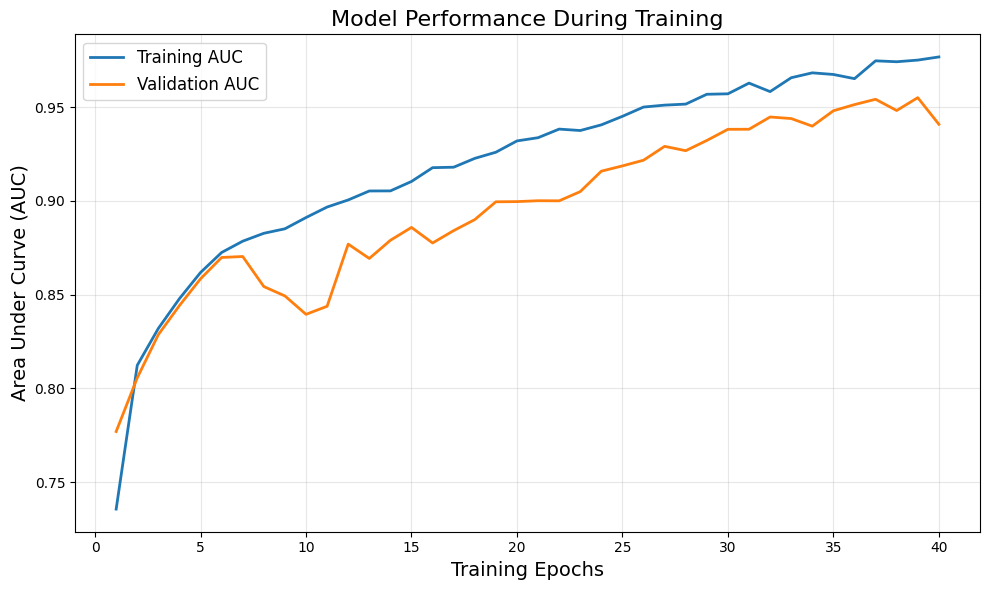


Training completed after 40 epochs (out of 40 max)
Final Training AUC: 0.9767
Final Validation AUC: 0.9408
Overfitting Gap: 0.0359
Training completed all epochs without early stopping.


In [15]:
# Prepare datasets for model training
training_molecular_dataset = create_molecular_neural_dataset(molecular_features_train, permeability_labels_train)
validation_molecular_dataset = create_molecular_neural_dataset(molecular_features_validation, permeability_labels_validation)
testing_molecular_dataset = create_molecular_neural_dataset(molecular_features_test, permeability_labels_test)

# Configure training parameters
NEURAL_NETWORK_EPOCHS = 40
IMBALANCE_COMPENSATION_WEIGHTS = {0: 2.0, 1: 0.5}  # Adjust for class imbalance

# Configure early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_AUC',           # Monitor validation AUC
    patience=10,                 # Wait 10 epochs for improvement
    mode='max',                  # AUC should be maximized
    restore_best_weights=True,   # Restore best weights when stopped
    verbose=1                    # Print message when stopping
)

# Optional: Add model checkpointing to save best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_mpnn_model.h5',
    monitor='val_AUC',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Optional: Add learning rate reduction on plateau
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC',
    factor=0.5,                  # Reduce LR by half
    patience=5,                  # Wait 5 epochs before reducing
    mode='max',
    min_lr=1e-6,
    verbose=1
)

# Train the molecular property prediction model with callbacks
print("Starting MPNN training with early stopping...")
neural_network_training_log = brain_barrier_prediction_model.fit(
    training_molecular_dataset,
    validation_data=validation_molecular_dataset,
    epochs=NEURAL_NETWORK_EPOCHS,
    verbose=2,
    class_weight=IMBALANCE_COMPENSATION_WEIGHTS,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]  # Add callbacks
)

# Create sophisticated training progress visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot training and validation curves with gradient colors
epochs = range(1, len(neural_network_training_log.history["AUC"]) + 1)

ax.plot(epochs, neural_network_training_log.history["AUC"], 
        label="Training AUC", linewidth=2)
ax.plot(epochs, neural_network_training_log.history["val_AUC"], 
        label="Validation AUC", linewidth=2)

# Add vertical line showing when early stopping occurred
if len(epochs) < NEURAL_NETWORK_EPOCHS:
    ax.axvline(x=len(epochs), color='red', linestyle='--', alpha=0.7, 
               label=f'Early Stopping (Epoch {len(epochs)})')

# Enhanced styling
ax.set_xlabel("Training Epochs", fontsize=14)
ax.set_ylabel("Area Under Curve (AUC)", fontsize=14)
ax.set_title("Model Performance During Training", fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final performance metrics with early stopping info
final_training_auc = neural_network_training_log.history["AUC"][-1]
final_validation_auc = neural_network_training_log.history["val_AUC"][-1]
actual_epochs = len(neural_network_training_log.history["AUC"])

print(f"\nTraining completed after {actual_epochs} epochs (out of {NEURAL_NETWORK_EPOCHS} max)")
print(f"Final Training AUC: {final_training_auc:.4f}")
print(f"Final Validation AUC: {final_validation_auc:.4f}")
print(f"Overfitting Gap: {abs(final_training_auc - final_validation_auc):.4f}")

if actual_epochs < NEURAL_NETWORK_EPOCHS:
    print(f"Early stopping triggered! Training stopped {NEURAL_NETWORK_EPOCHS - actual_epochs} epochs early.")
    print("Best weights have been restored.")
else:
    print("Training completed all epochs without early stopping.")

## Model Inference and Results Visualization

Evaluating trained model performance on test molecules

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Test Set Prediction Analysis
Test Accuracy: 90.62%
Total Test Samples: 32
Correct Predictions: 29
Incorrect Predictions: 3

Molecular Structure Predictions:


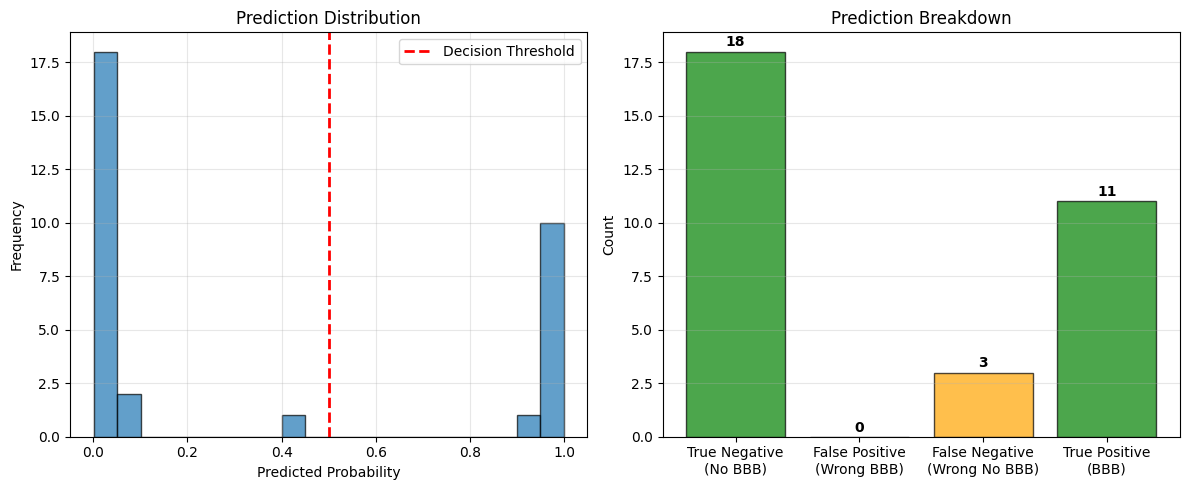

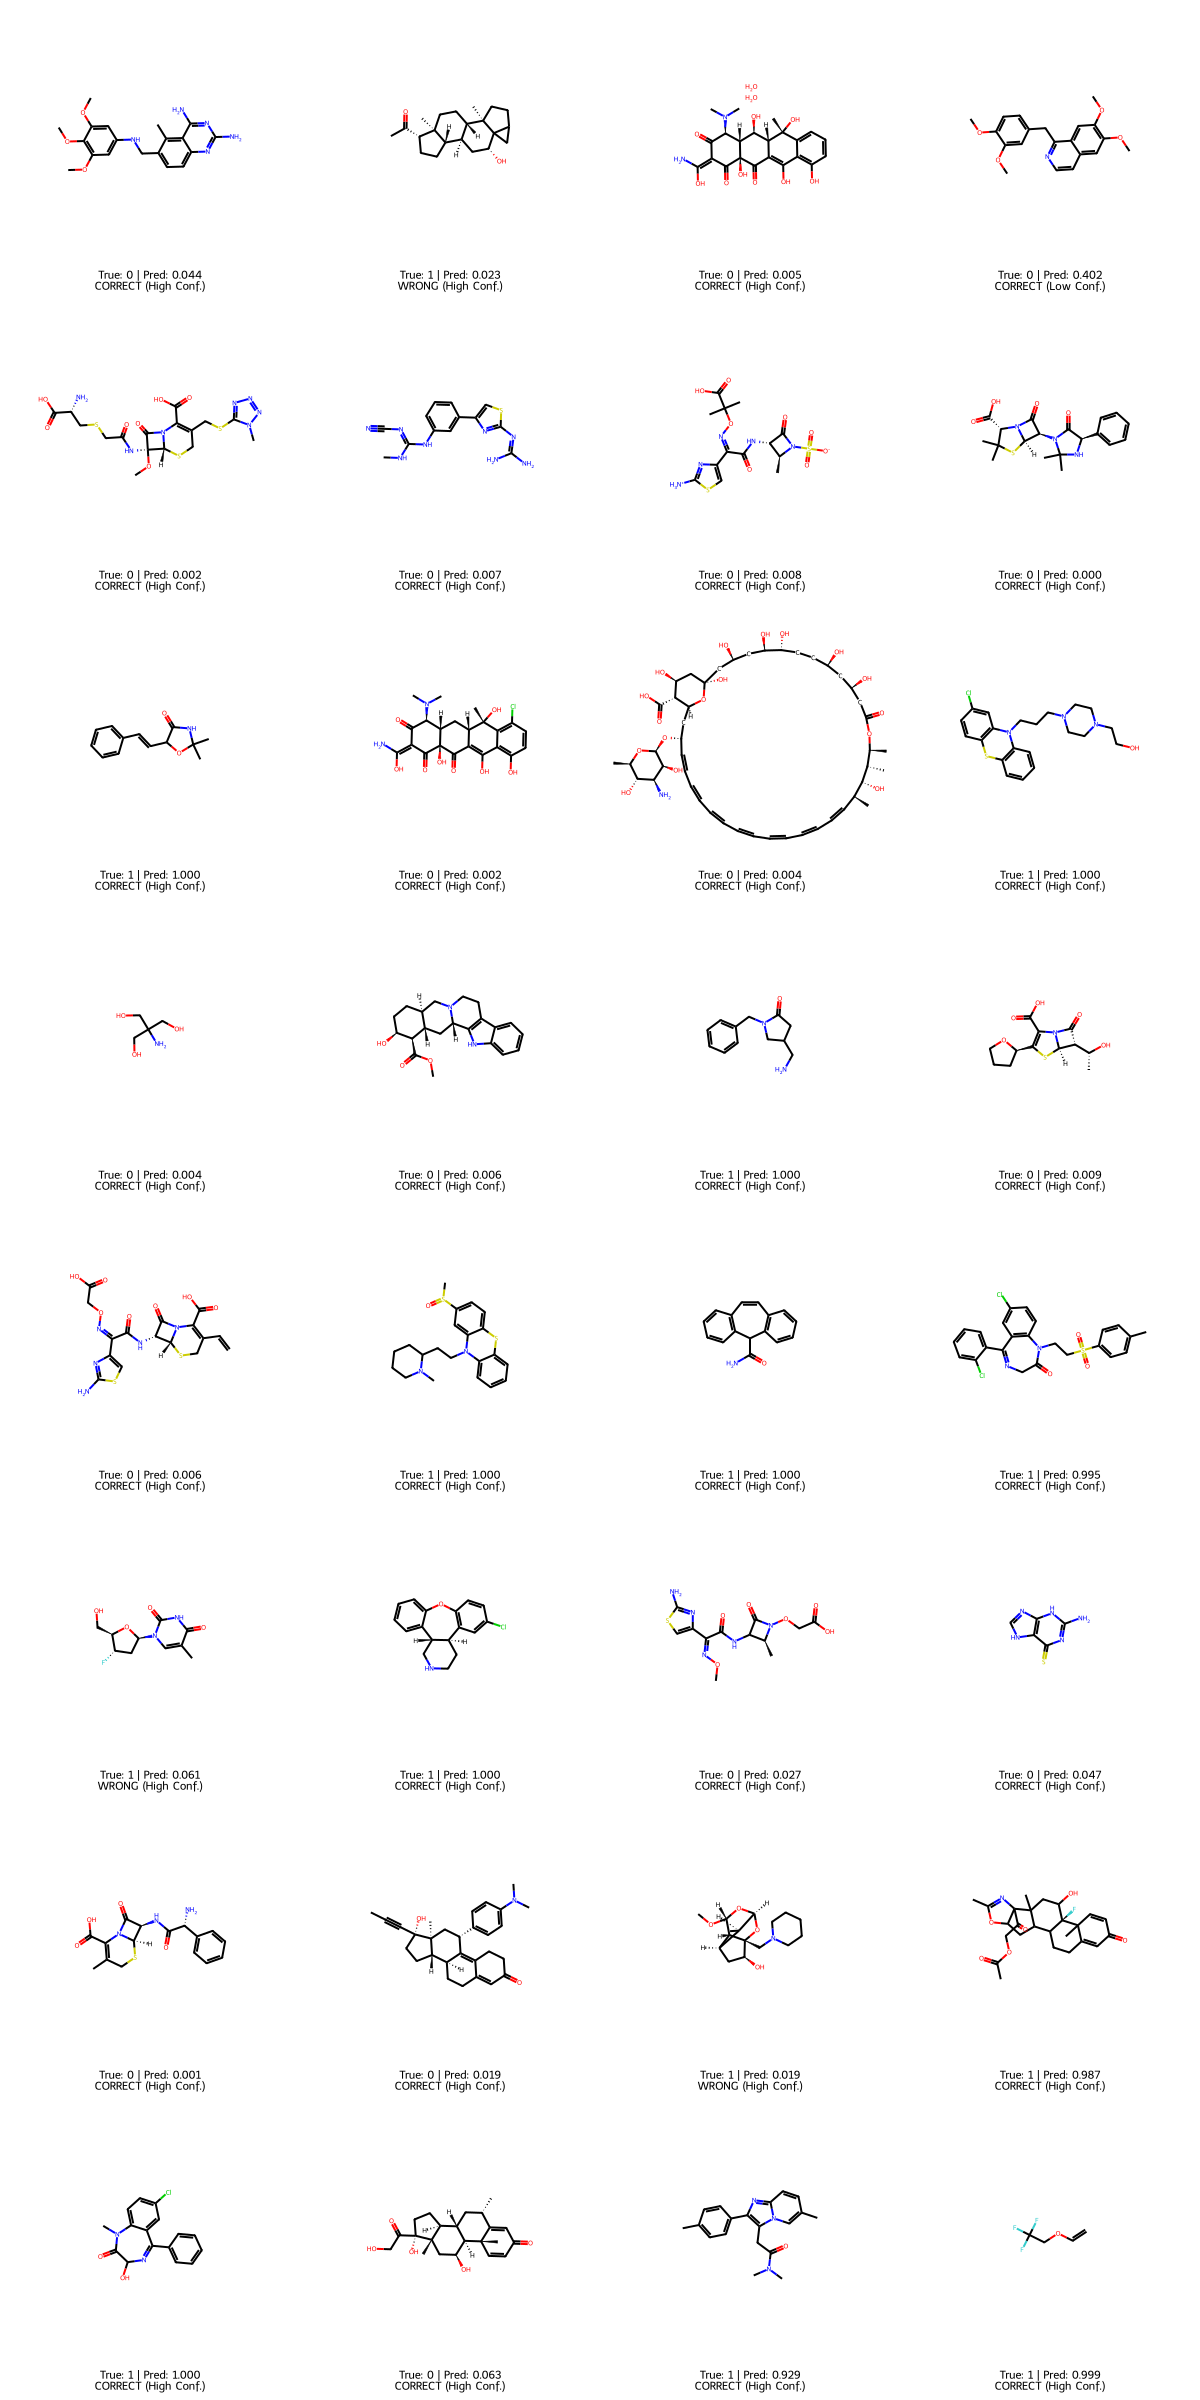

In [19]:
# Generate molecular objects for test set visualization
test_molecular_structures = [convert_smiles_to_molecule(molecular_dataframe.smiles.values[idx]) for idx in testing_sample_indices]

# Extract ground truth labels
actual_permeability_labels = [molecular_dataframe.permeability_target.values[idx] for idx in testing_sample_indices]

# Generate model predictions
predicted_barrier_probabilities = tf.squeeze(brain_barrier_prediction_model.predict(testing_molecular_dataset), axis=1)

# Create sophisticated prediction analysis
print("Test Set Prediction Analysis")
print("=" * 50)

# Calculate prediction statistics
correct_prediction_count = sum(1 for i in range(len(actual_permeability_labels)) 
                         if (predicted_barrier_probabilities[i] > 0.5) == actual_permeability_labels[i])
classification_accuracy = correct_prediction_count / len(actual_permeability_labels)

print(f"Test Accuracy: {classification_accuracy:.2%}")
print(f"Total Test Samples: {len(actual_permeability_labels)}")
print(f"Correct Predictions: {correct_prediction_count}")
print(f"Incorrect Predictions: {len(actual_permeability_labels) - correct_prediction_count}")

# Enhanced molecular visualization
print("\nMolecular Structure Predictions:")
print("=" * 50)

# Create enhanced legends with color coding
visualization_legends = []
for i in range(len(actual_permeability_labels)):
    prediction_value = predicted_barrier_probabilities[i]
    actual_value = actual_permeability_labels[i]
    
    # Color code based on correctness
    if (prediction_value > 0.5) == actual_value:
        status = "CORRECT"
        confidence = "High" if abs(prediction_value - 0.5) > 0.3 else "Low"
    else:
        status = "WRONG"
        confidence = "High" if abs(prediction_value - 0.5) > 0.3 else "Low"
    
    legend = f"True: {actual_value} | Pred: {prediction_value:.3f}\n{status} ({confidence} Conf.)"
    visualization_legends.append(legend)

# Display molecules with enhanced visualization
molecular_grid_display = MolsToGridImage(
    test_molecular_structures, 
    molsPerRow=4, 
    legends=visualization_legends,
    subImgSize=(300, 300),
    useSVG=False
)

# Create a performance breakdown visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Prediction distribution histogram
histogram_bins = 20
ax1.hist(predicted_barrier_probabilities, bins=histogram_bins, alpha=0.7, edgecolor='black')
ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('Frequency')
ax1.set_title('Prediction Distribution')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Confusion matrix-style visualization
confusion_categories = ['True Negative\n(No BBB)', 'False Positive\n(Wrong BBB)', 
              'False Negative\n(Wrong No BBB)', 'True Positive\n(BBB)']
true_negative_count = sum(1 for i in range(len(actual_permeability_labels)) 
         if actual_permeability_labels[i] == 0 and predicted_barrier_probabilities[i] <= 0.5)
false_positive_count = sum(1 for i in range(len(actual_permeability_labels)) 
         if actual_permeability_labels[i] == 0 and predicted_barrier_probabilities[i] > 0.5)
false_negative_count = sum(1 for i in range(len(actual_permeability_labels)) 
         if actual_permeability_labels[i] == 1 and predicted_barrier_probabilities[i] <= 0.5)
true_positive_count = sum(1 for i in range(len(actual_permeability_labels)) 
         if actual_permeability_labels[i] == 1 and predicted_barrier_probabilities[i] > 0.5)

confusion_counts = [true_negative_count, false_positive_count, false_negative_count, true_positive_count]
category_colors = ['green', 'orange', 'orange', 'green']

confusion_bars = ax2.bar(confusion_categories, confusion_counts, color=category_colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Count')
ax2.set_title('Prediction Breakdown')
ax2.grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for bar, count in zip(confusion_bars, confusion_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

molecular_grid_display

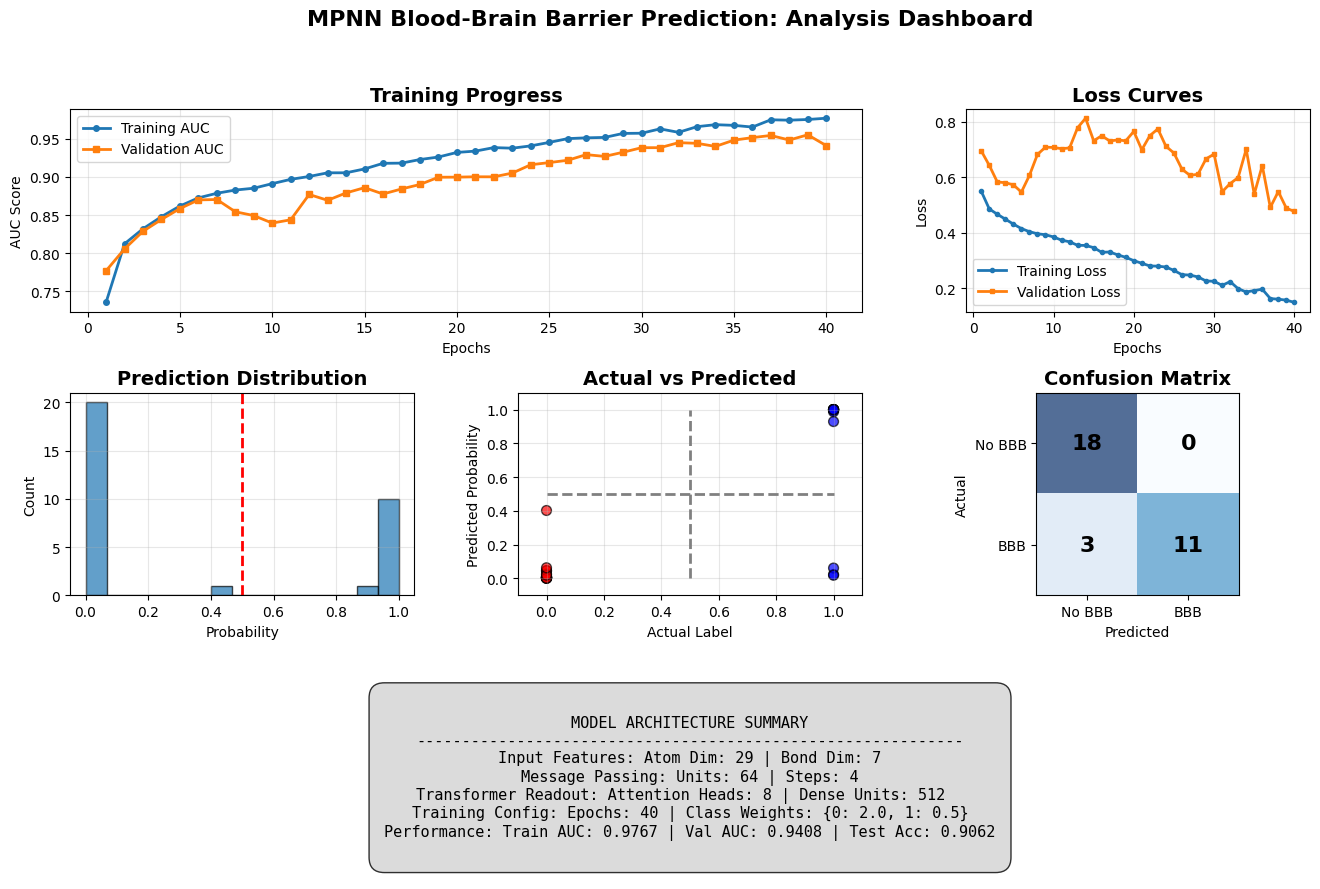

In [17]:
# Create comprehensive model performance dashboard
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)

# 1. Training History (Top Left - spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
epochs = range(1, len(neural_network_training_log.history["AUC"]) + 1)
ax1.plot(epochs, neural_network_training_log.history["AUC"], 'o-', linewidth=2, markersize=4, label='Training AUC')
ax1.plot(epochs, neural_network_training_log.history["val_AUC"], 's-', linewidth=2, markersize=4, label='Validation AUC')
ax1.set_title('Training Progress', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('AUC Score')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Loss History (Top Right)
ax2 = fig.add_subplot(gs[0, 2])
if 'loss' in neural_network_training_log.history:
    ax2.plot(epochs, neural_network_training_log.history["loss"], 'o-', linewidth=2, markersize=3, label='Training Loss')
    if 'val_loss' in neural_network_training_log.history:
        ax2.plot(epochs, neural_network_training_log.history["val_loss"], 's-', linewidth=2, markersize=3, label='Validation Loss')
    ax2.set_title('Loss Curves', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

# 3. Prediction Distribution (Middle Left)
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(predicted_barrier_probabilities, bins=15, alpha=0.7, edgecolor='black')
ax3.axvline(x=0.5, color='red', linestyle='--', linewidth=2)
ax3.set_title('Prediction Distribution', fontsize=14, fontweight='bold')
ax3.set_xlabel('Probability')
ax3.set_ylabel('Count')
ax3.grid(True, alpha=0.3)

# 4. Actual vs Predicted Scatter (Middle Center)
ax4 = fig.add_subplot(gs[1, 1])
scatter_colors = ['red' if actual_permeability_labels[i] == 0 else 'blue' for i in range(len(actual_permeability_labels))]
ax4.scatter(actual_permeability_labels, predicted_barrier_probabilities, c=scatter_colors, alpha=0.7, s=50, edgecolors='black')
ax4.plot([0, 1], [0.5, 0.5], '--', color='gray', linewidth=2)
ax4.plot([0.5, 0.5], [0, 1], '--', color='gray', linewidth=2)
ax4.set_title('Actual vs Predicted', fontsize=14, fontweight='bold')
ax4.set_xlabel('Actual Label')
ax4.set_ylabel('Predicted Probability')
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-0.1, 1.1)
ax4.set_ylim(-0.1, 1.1)

# 5. Confusion Matrix (Middle Right)
ax5 = fig.add_subplot(gs[1, 2])
confusion_matrix_array = np.array([[true_negative_count, false_positive_count], [false_negative_count, true_positive_count]])
im = ax5.imshow(confusion_matrix_array, cmap='Blues', alpha=0.7)
ax5.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax5.set_xlabel('Predicted')
ax5.set_ylabel('Actual')
ax5.set_xticks([0, 1])
ax5.set_yticks([0, 1])
ax5.set_xticklabels(['No BBB', 'BBB'])
ax5.set_yticklabels(['No BBB', 'BBB'])

# Add text annotations
for i in range(2):
    for j in range(2):
        ax5.text(j, i, confusion_matrix_array[i, j], ha="center", va="center", 
                fontsize=16, fontweight='bold')

# 6. Model Architecture Summary (Bottom - spans all columns)
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

# Create architecture text
architecture_summary = f"""
MODEL ARCHITECTURE SUMMARY
{'-'*60}
Input Features: Atom Dim: {molecular_features_train[0][0][0].shape[0]} | Bond Dim: {molecular_features_train[1][0][0].shape[0]}
Message Passing: Units: 64 | Steps: 4
Transformer Readout: Attention Heads: 8 | Dense Units: 512  
Training Config: Epochs: {NEURAL_NETWORK_EPOCHS} | Class Weights: {IMBALANCE_COMPENSATION_WEIGHTS}
Performance: Train AUC: {neural_network_training_log.history["AUC"][-1]:.4f} | Val AUC: {neural_network_training_log.history["val_AUC"][-1]:.4f} | Test Acc: {classification_accuracy:.4f}
"""

ax6.text(0.5, 0.5, architecture_summary, ha='center', va='center', fontsize=11, 
         fontfamily='monospace', 
         bbox=dict(boxstyle="round,pad=1", facecolor='lightgray', alpha=0.8))

plt.suptitle('MPNN Blood-Brain Barrier Prediction: Analysis Dashboard', 
             fontsize=16, fontweight='bold')
plt.show()

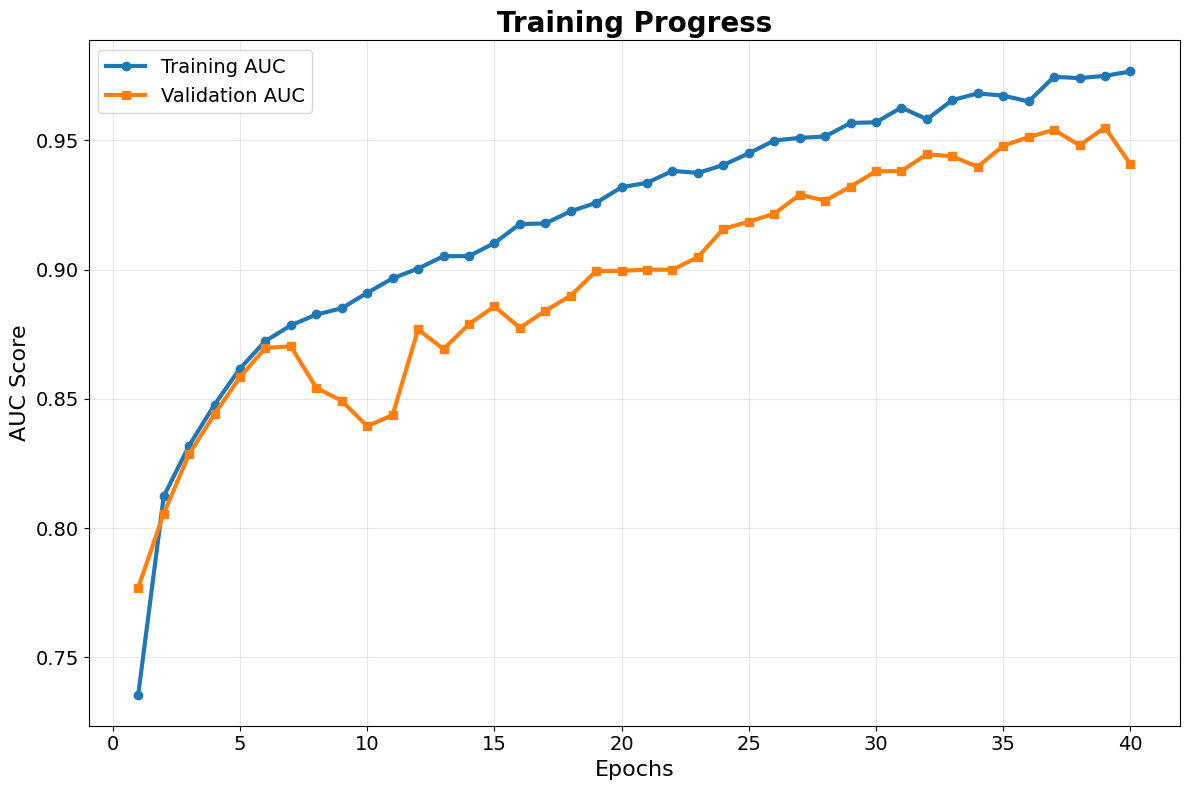

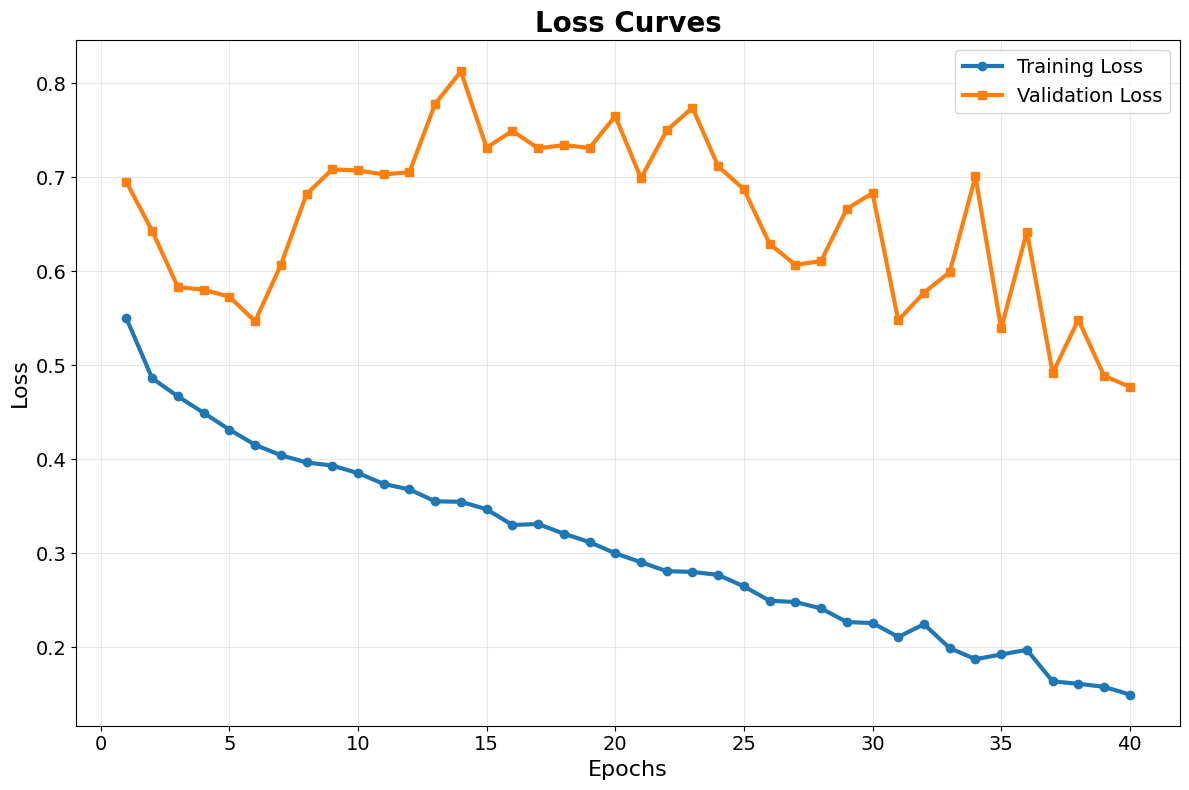

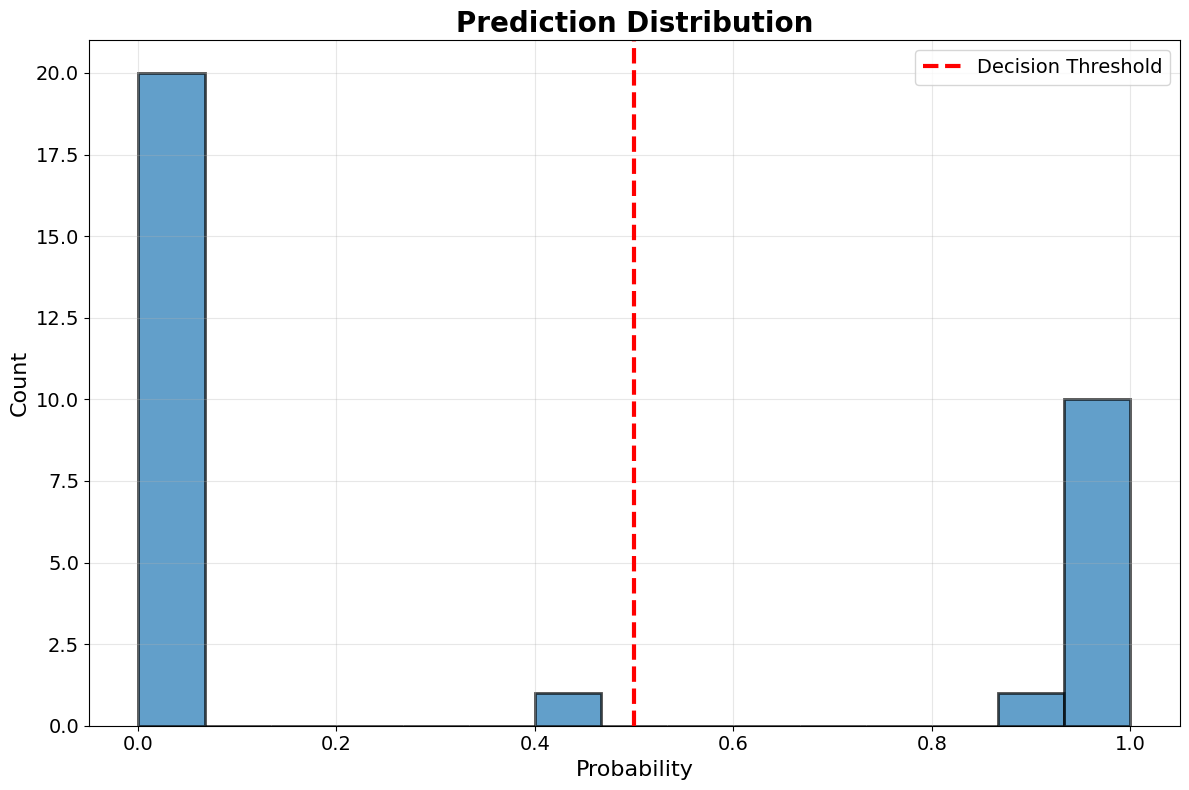

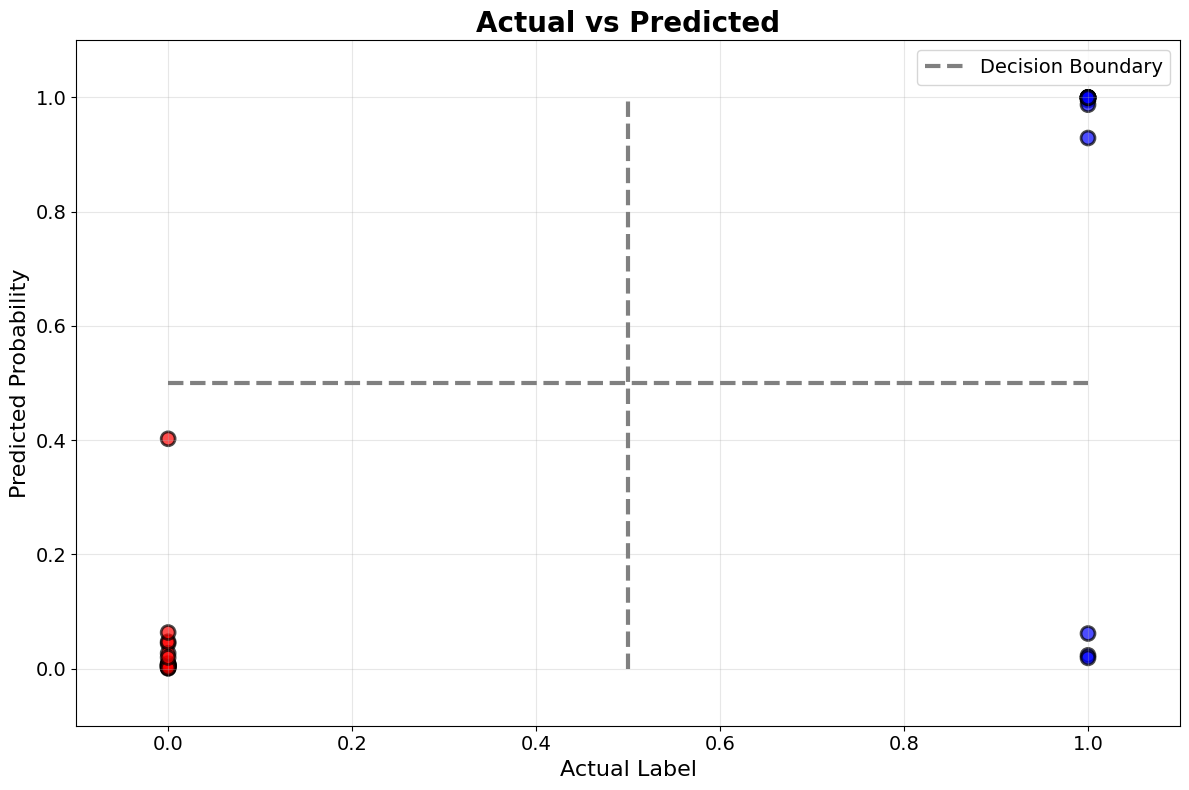

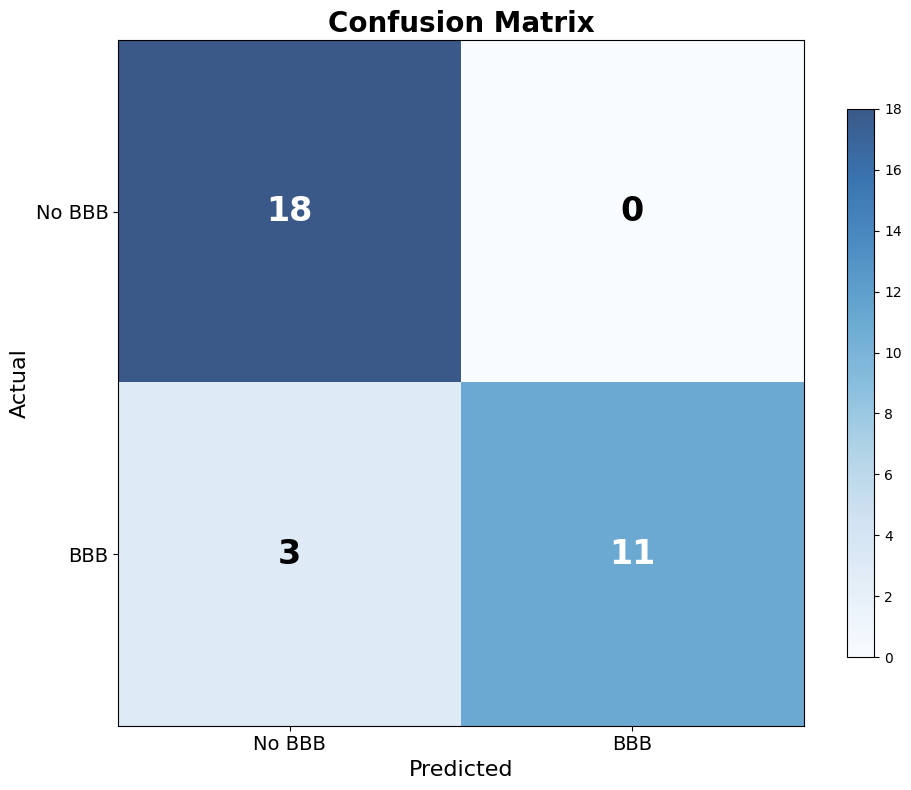

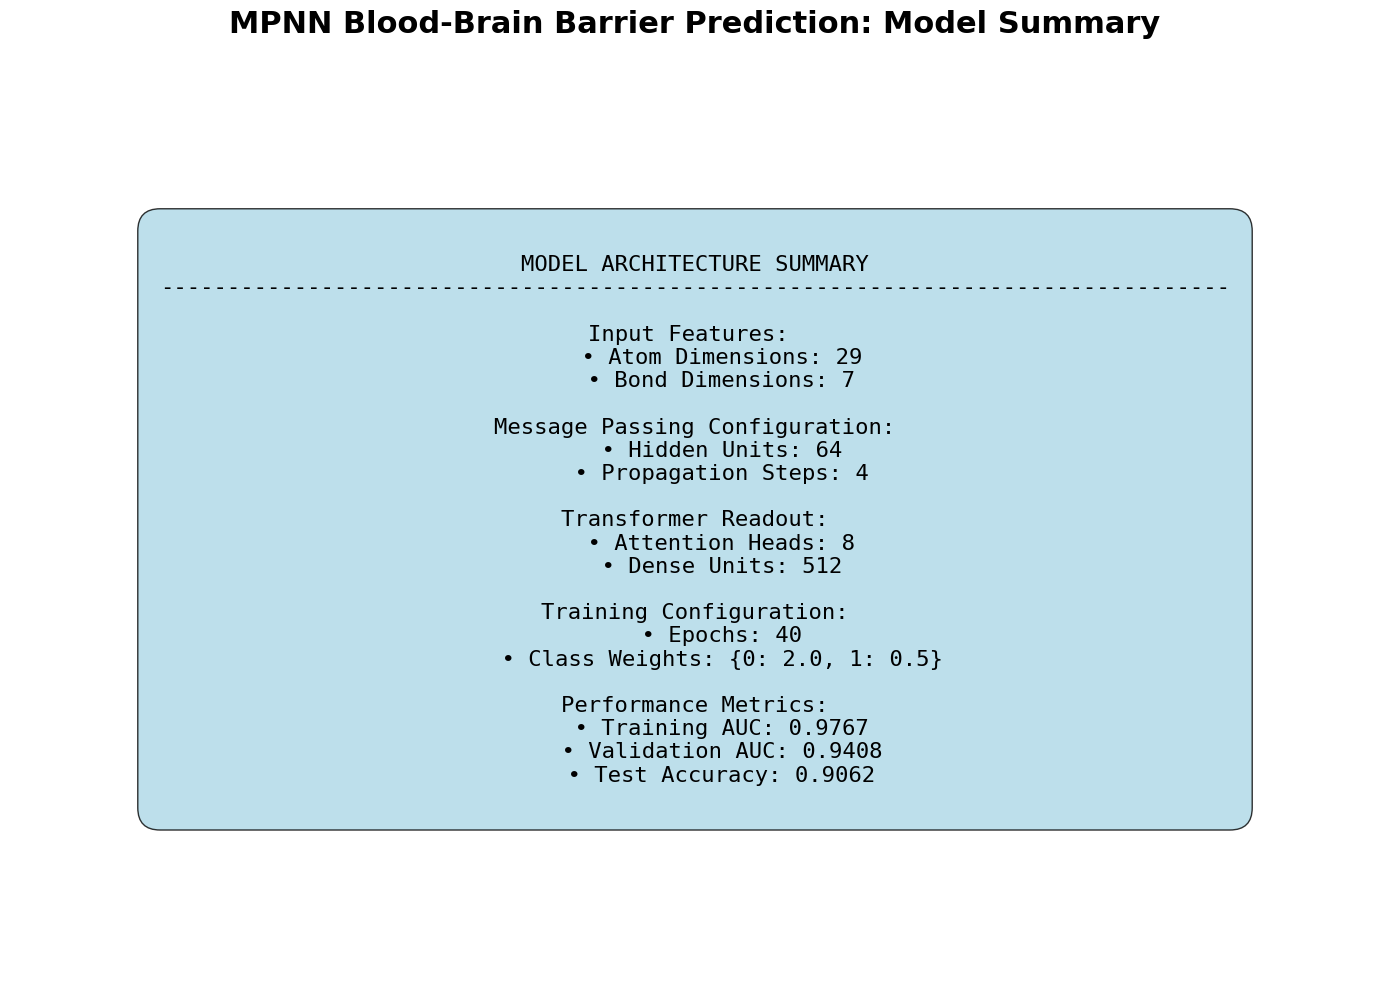

In [18]:
import numpy as np

import matplotlib.pyplot as plt

# 1. Training Progress Plot
plt.figure(figsize=(12, 8))
epochs = range(1, len(neural_network_training_log.history["AUC"]) + 1)
plt.plot(epochs, neural_network_training_log.history["AUC"], 'o-', linewidth=3, markersize=6, label='Training AUC')
plt.plot(epochs, neural_network_training_log.history["val_AUC"], 's-', linewidth=3, markersize=6, label='Validation AUC')
plt.title('Training Progress', fontsize=20, fontweight='bold')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('AUC Score', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# 2. Loss History Plot
plt.figure(figsize=(12, 8))
if 'loss' in neural_network_training_log.history:
    plt.plot(epochs, neural_network_training_log.history["loss"], 'o-', linewidth=3, markersize=6, label='Training Loss')
    if 'val_loss' in neural_network_training_log.history:
        plt.plot(epochs, neural_network_training_log.history["val_loss"], 's-', linewidth=3, markersize=6, label='Validation Loss')
    plt.title('Loss Curves', fontsize=20, fontweight='bold')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

# 3. Prediction Distribution Plot
plt.figure(figsize=(12, 8))
plt.hist(predicted_barrier_probabilities, bins=15, alpha=0.7, edgecolor='black', linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=3, label='Decision Threshold')
plt.title('Prediction Distribution', fontsize=20, fontweight='bold')
plt.xlabel('Probability', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# 4. Actual vs Predicted Scatter Plot
plt.figure(figsize=(12, 8))
scatter_colors = ['red' if actual_permeability_labels[i] == 0 else 'blue' for i in range(len(actual_permeability_labels))]
plt.scatter(actual_permeability_labels, predicted_barrier_probabilities, c=scatter_colors, alpha=0.7, s=100, edgecolors='black', linewidth=2)
plt.plot([0, 1], [0.5, 0.5], '--', color='gray', linewidth=3, label='Decision Boundary')
plt.plot([0.5, 0.5], [0, 1], '--', color='gray', linewidth=3)
plt.title('Actual vs Predicted', fontsize=20, fontweight='bold')
plt.xlabel('Actual Label', fontsize=16)
plt.ylabel('Predicted Probability', fontsize=16)
plt.grid(True, alpha=0.3)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# 5. Confusion Matrix Plot
plt.figure(figsize=(10, 8))
confusion_matrix_array = np.array([[true_negative_count, false_positive_count], [false_negative_count, true_positive_count]])
im = plt.imshow(confusion_matrix_array, cmap='Blues', alpha=0.8)
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xticks([0, 1], ['No BBB', 'BBB'], fontsize=14)
plt.yticks([0, 1], ['No BBB', 'BBB'], fontsize=14)

# Add text annotations with larger font
for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix_array[i, j], ha="center", va="center", 
                fontsize=24, fontweight='bold', color='white' if confusion_matrix_array[i, j] > confusion_matrix_array.max()/2 else 'black')

plt.colorbar(im, shrink=0.8)
plt.tight_layout()
plt.show()

# 6. Model Performance Summary
plt.figure(figsize=(14, 10))
plt.axis('off')

# Create architecture text with larger font
architecture_summary = f"""
MODEL ARCHITECTURE SUMMARY
{'-'*80}

Input Features: 
    • Atom Dimensions: {molecular_features_train[0][0][0].shape[0]}
    • Bond Dimensions: {molecular_features_train[1][0][0].shape[0]}

Message Passing Configuration:
    • Hidden Units: 64
    • Propagation Steps: 4

Transformer Readout:
    • Attention Heads: 8
    • Dense Units: 512

Training Configuration:
    • Epochs: {NEURAL_NETWORK_EPOCHS}
    • Class Weights: {IMBALANCE_COMPENSATION_WEIGHTS}

Performance Metrics:
    • Training AUC: {neural_network_training_log.history["AUC"][-1]:.4f}
    • Validation AUC: {neural_network_training_log.history["val_AUC"][-1]:.4f}
    • Test Accuracy: {classification_accuracy:.4f}
"""

plt.text(0.5, 0.5, architecture_summary, ha='center', va='center', fontsize=16, 
         fontfamily='monospace', 
         bbox=dict(boxstyle="round,pad=1", facecolor='lightblue', alpha=0.8))

plt.title('MPNN Blood-Brain Barrier Prediction: Model Summary', 
          fontsize=22, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()